In [174]:
import sys
sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')
from volatility import Panel_GARCH, Panel_GARCH_SLSQP, GARCH
from stats import panel_DM, dm_test

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import math

# First let's check what can we observe in the standard DM test:

In [88]:
np.random.seed(14)
params = [0.0, 0.1, 0.05, 0.85]
model = GARCH()
r, sigma2 = model.simulate(params = params)
model.fit(['', '01', '01', '01'], r)

Loglikelihood:  1.4442807520919727 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0   -0.131650        0.042460     -0.214869      -0.048430
1    0.069601        0.205954     -0.334060       0.473263
2    0.034661        0.182007     -0.322066       0.391387
3    0.899542        0.144144      0.617025       1.182059


In [104]:
pred1 = model.model_filter(model.optimized_params, r)
np.random.seed(2)
eps = np.ones(pred1.shape) + np.random.normal(scale = 0.2, size = pred1.shape)
pred2 = pred1 * eps

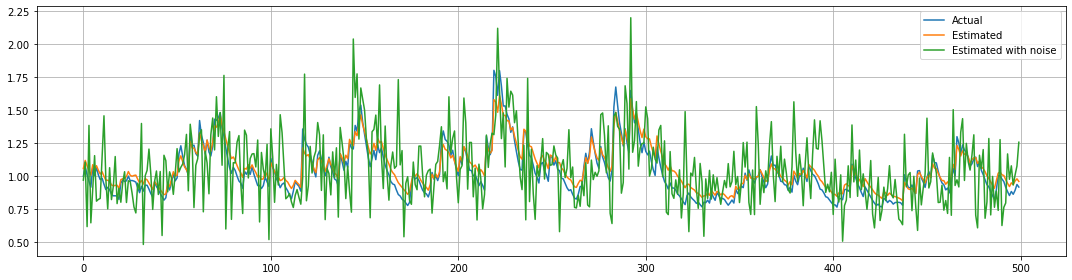

In [105]:
plt.figure(figsize =(15,4))
plt.plot(sigma2, label = 'Actual')
plt.plot(pred1, label = 'Estimated')
plt.plot(pred2, label = 'Estimated with noise')
plt.legend(loc = 'best')
plt.grid()
plt.tight_layout()
plt.show()

Negative number means that the first prediction is better then the second:

In [107]:
dm_test(sigma2, pred1, pred2)

(-13.482372624533383, 1.5095505892697148e-35)

In [114]:
pred1 = model.model_filter(model.optimized_params, r)
np.random.seed(2)
eps = np.ones(pred1.shape) + np.random.normal(scale = 0.05, size = pred1.shape)
pred2 = pred1 * eps

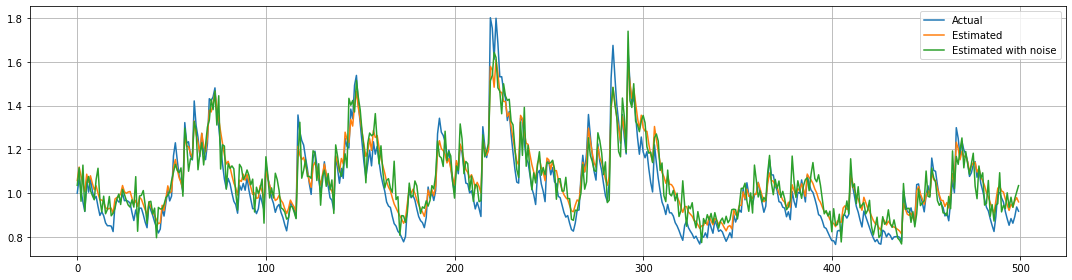

In [115]:
plt.figure(figsize =(15,4))
plt.plot(sigma2, label = 'Actual')
plt.plot(pred1, label = 'Estimated')
plt.plot(pred2, label = 'Estimated with noise')
plt.legend(loc = 'best')
plt.grid()
plt.tight_layout()
plt.show()

With that much noise the first prediction is much better:

In [116]:
dm_test(sigma2, pred1, pred2)

(-7.711754187688862, 6.783081548505987e-14)

In [117]:
pred1 = model.model_filter(model.optimized_params, r)
np.random.seed(2)
eps = np.ones(pred1.shape) + np.random.normal(scale = 0.01, size = pred1.shape)
pred2 = pred1 * eps

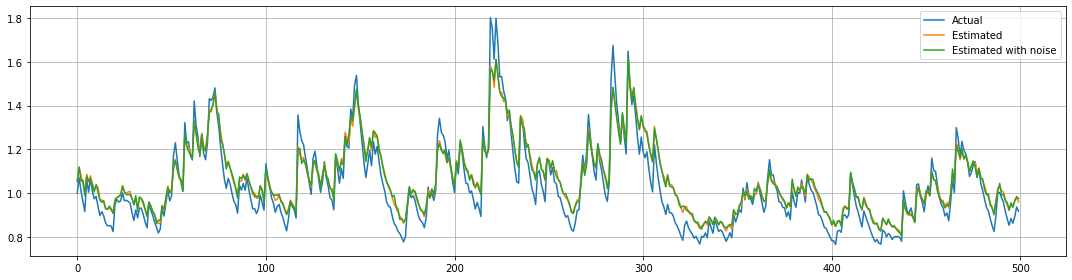

In [118]:
plt.figure(figsize =(15,4))
plt.plot(sigma2, label = 'Actual')
plt.plot(pred1, label = 'Estimated')
plt.plot(pred2, label = 'Estimated with noise')
plt.legend(loc = 'best')
plt.grid()
plt.tight_layout()
plt.show()

The null hypothesis can be accepted if the added noise is that much as you can see above

In [119]:
dm_test(sigma2, pred1, pred2)

(-1.1893215163439366, 0.23487878221513184)

# Now, let's turn into the panel version:

In [274]:
def family_of_loss_func(actual, predicted, degree):
    """
    Implemented from:
    Patton, A. J., 2011. Volatility forecasting comparison using imperfect 
    volatility proxies, Journal of Econometrics 160, 246-256.
    """
    if degree == -2:
        # QLIKE
        loss = actual / predicted - np.log(actual / predicted) - 1
    elif degree == -1:
        loss = predicted - actual + actual * np.log(actual / predicted)
    else:
        # MSE if degree = 0
        loss = (np.sqrt(actual) ** (2 * degree + 4) - predicted ** (degree + 2)) / ((degree + 1) * (degree + 2))
        loss -= (1 / (degree + 1)) * (predicted ** (degree + 1)) * (actual - predicted)
    return loss

def panel_DM_V1(act, pred1, pred2, degree = 0):
    """
    Implemented from:
    Timmermann, A., Zhu, Y., 2019. Comparing Forecasting Performance with Panel Data
    """
    l1 = family_of_loss_func(act, pred1, degree)
    l2 = family_of_loss_func(act, pred2, degree)
    l1_mean = np.nanmean(l1)
    l2_mean = np.nanmean(l2)
    delta_l = l1 - l2
    n_T_sqrt = np.sqrt(np.sum(~np.isnan(delta_l)))
    sum_delta_l = np.nansum(delta_l)
    sigma_delta_l = np.nanstd(delta_l)
    j_dm = sum_delta_l / (sigma_delta_l * n_T_sqrt)
    p_value = 2 * t.cdf(-np.abs(j_dm), df = np.sum(~np.isnan(delta_l)) - 1)
    return j_dm, p_value

def panel_DM_V2(act, pred1, pred2, degree = 0):
    l1 = family_of_loss_func(act, pred1, degree)
    l2 = family_of_loss_func(act, pred2, degree)
    d12 = l1 - l2
    nT = np.sum(~np.isnan(d12))
    d12_m = np.nanmean(d12, axis = 0)
    # Itt azért osztunk csak nT-vel és nem np.sqrt(nT)-vel, mert 
    # amikor az nT-t kihozzuk a Var-ból akkor annak a négyzetével számolunk
    var = np.nansum((d12 - np.nanmean(d12, axis = 0)) * (d12 - np.nanmean(d12, axis = 0))) / nT
    std = math.sqrt(var)
    m = np.nansum(d12) / math.sqrt(nT)
    DM = m / std
    p_value = 2 * t.cdf(-np.abs(DM), df = nT-1)
    return DM, p_value

def panel_DM_V3(act, pred1, pred2, degree = 0):
    l1 = family_of_loss_func(act, pred1, degree)
    l2 = family_of_loss_func(act, pred2, degree)
    d12 = l1 - l2
    nT = np.sum(~np.isnan(d12))
    n = np.sum(~np.isnan(d12), axis = 1)
    T = d12.shape[0]
    Rt = np.sqrt(n) * np.nansum(d12, axis = 1) / n
    Rt_hat = Rt - np.nansum(Rt) / T
    gamma0 = np.nansum(Rt_hat * Rt_hat) / T
    Rt1 = Rt[1:] - np.nansum(Rt[1:]) / (T - 1)
    Rt11 = Rt[:-1] - np.nansum(Rt[:-1]) / (T - 1)
    gamma1 = np.nansum(Rt1 * Rt11) / (T - 1)
    std = math.sqrt(gamma0 + 2 * gamma1)
    m = np.nansum(d12) / np.sqrt(nT)
    DM = m / std
    p_value = 2 * t.cdf(-np.abs(DM), df = nT-1)
    return DM, p_value

In [223]:
np.random.seed(14)
params = [0.05, 0.9]
model = Panel_GARCH()
act, r = model.simulate(params = params)
model.fit(['01', '01'], pd.DataFrame(r))

Loglikelihood:  140.43681804316927 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.045369        0.012947      0.019993       0.070745
1    0.902210        0.012207      0.878286       0.926135


In [275]:
pred1 = model.model_filter(model.optimized_params, pd.DataFrame(r))
np.random.seed(2)
eps = np.ones(pred1.shape) + np.random.normal(scale = 0.2,  size = pred1.shape)
pred2 = pred1 * eps

In [276]:
panel_DM(act, pred1, pred2)

(-178.70644915931885, 0.0)

In [277]:
panel_DM_V1(act, pred1, pred2)

(-182.31207150498307, 0.0)

In [278]:
panel_DM_V2(act, pred1, pred2)

(-183.60499412653624, 0.0)

In [279]:
panel_DM_V3(act, pred1, pred2)

(-178.706402315584, 0.0)

In [280]:
pred1 = model.model_filter(model.optimized_params, pd.DataFrame(r))
np.random.seed(2)
eps = np.ones(pred1.shape) + np.random.normal(scale = 0.05,  size = pred1.shape)
pred2 = pred1 * eps

In [281]:
panel_DM(act, pred1, pred2)

(-126.5346285176534, 0.0)

In [282]:
panel_DM_V1(act, pred1, pred2)

(-119.03256059869797, 0.0)

In [283]:
panel_DM_V2(act, pred1, pred2)

(-119.37508451504924, 0.0)

In [284]:
panel_DM_V3(act, pred1, pred2)

(-126.53460552671096, 0.0)

In [285]:
pred1 = model.model_filter(model.optimized_params, pd.DataFrame(r))
np.random.seed(2)
eps = np.ones(pred1.shape) + np.random.normal(scale = 0.01, size = pred1.shape)
pred2 = pred1 * eps

In [286]:
panel_DM(act, pred1, pred2)

(-30.461821271381012, 7.128988892747453e-203)

In [287]:
panel_DM_V1(act, pred1, pred2)

(-28.74169858601211, 6.301375923059028e-181)

In [288]:
panel_DM_V2(act, pred1, pred2)

(-28.75563029983005, 4.2336034184138387e-181)

In [289]:
panel_DM_V3(act, pred1, pred2)

(-30.461820194585446, 7.129220834807724e-203)

In [290]:
pred1 = model.model_filter(model.optimized_params, pd.DataFrame(r))
np.random.seed(2)
eps = np.ones(pred1.shape) + np.random.normal(scale = 0.005, size = pred1.shape)
pred2 = pred1 * eps

In [291]:
panel_DM(act, pred1, pred2)

(-14.524149165486763, 9.530405115571269e-48)

In [292]:
panel_DM_V1(act, pred1, pred2)

(-13.814542330069239, 2.2831825318323688e-43)

In [293]:
panel_DM_V2(act, pred1, pred2)

(-13.820569108027648, 2.1001794329421305e-43)

In [294]:
panel_DM_V3(act, pred1, pred2)

(-14.524148860432872, 9.530447450541996e-48)

In [295]:
pred1 = model.model_filter(model.optimized_params, pd.DataFrame(r))
np.random.seed(2)
eps = np.ones(pred1.shape) + np.random.normal(scale = 0.001, size = pred1.shape)
pred2 = pred1 * eps

In [296]:
panel_DM(act, pred1, pred2)

(-1.7814837345653047, 0.0748364938523198)

In [297]:
panel_DM_V1(act, pred1, pred2)

(-1.7072714821184654, 0.08777470837371629)

In [298]:
panel_DM_V2(act, pred1, pred2)

(-1.708066147464514, 0.08762717305977383)

In [299]:
panel_DM_V3(act, pred1, pred2)

(-1.7814837130563956, 0.07483649736310795)